# Assignment 1 Part 1 Instructions **[50 marks]**

## Overview
You are required to develop a **Retrieval-Augmented Generation (RAG) system** from scratch. This includes implementing embeddings, storing them in a vector database, building a retriever, and chaining it with an LLM. You will then **experiment with retrieval parameters** and analyze their effects on system accuracy. A bonus section will allow you to refine the system with **prompt engineering**.

---

## Part 1: Build the RAG Chain (20 marks)

### Requirements
- Implement embeddings and store them in a **vector database**.  
- Implement a retriever and build the **RAG chain** that connects it with an LLM.  
- Ensure the pipeline can retrieve relevant chunks and generate answers.  

---

## Part 2: Chaining for Extended Context (10 marks)

### Requirements
- Implement **chaining** that allows the LLM to go beyond retrieved context.  
- Demonstrate how chaining enables multi-step reasoning or broader context handling.  

---

## Part 3: Parameter Testing & Report (20 marks)

### Requirements
- Use the provided dataset of **20 questions** (10 with one-word answers, 10 with no answer).  
- Explore different values for:  
  - **Chunk size**  
  - **Chunk overlap**  
  - **Top-K retrieval**  
  - **Similarity cutoff threshold**  
- Record and analyze how parameter choices affect accuracy.  
- Submit a **report** summarizing:  
  - The results of your experiments.  
  - Explanations of why certain parameters improved or degraded performance.  

---

## Bonus: Prompt Engineering (5+5 marks)

### Requirements
- Refine your system using **prompt engineering** so that:  
  - For answerable questions → the LLM provides the correct answer.  
  - For unanswerable questions → the LLM responds with *“I don’t know”*.  

### Notes:
- Bonus marks can be used to recover deductions from earlier parts.  
- Creativity and clarity in prompt design will be rewarded.  
- Do **not** use GPT or other AI tools to generate code. Instead, consult the documentation — learning to use these tools independently is essential for your course projects.  

---

## Evaluation Criteria
- **Correctness**: The RAG chain should work end-to-end.  
- **Implementation**: Proper embeddings, vector DB, retriever, and chaining.  
- **Analysis**: Depth of reasoning in your parameter exploration report.  
- **Bonus (Optional)**: Effective prompt engineering to balance correctness and abstention.  

---

# Installation

First, we install the required packages:

- **LangChain** and **LangChain Community**: provide loaders, splitters, retrievers, etc.  
- **LangChain HuggingFace**: for embedding models.  
- **LangChain Pinecone** and **pinecone-client**: for vector database storage.  
- **python-dotenv**: for managing API keys securely.  
- **Streamlit**: (optional) for building a user interface.  
- **MistralAI client**: for the language model we’ll use.

This ensures our environment has all dependencies for building a RAG pipeline.

In [1]:
%pip install langchain langchain-community
%pip install langchain-huggingface pypdf
%pip install langchain-pinecone pinecone-client
%pip install python-dotenv streamlit
%pip install -qU langchain-mistralai

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
import os
import dotenv
from uuid import uuid4
import pandas as pd
from tqdm import tqdm
from pinecone import Pinecone, ServerlessSpec
from langchain.prompts import PromptTemplate
from langchain_core.runnables import RunnablePassthrough, RunnableLambda
from langchain_core.output_parsers import StrOutputParser
from langchain_community.embeddings import HuggingFaceEmbeddings
from langchain_pinecone import PineconeVectorStore
from langchain.document_loaders import PyPDFLoader
from langchain.text_splitter import RecursiveCharacterTextSplitter as RCTS
from langchain_mistralai import ChatMistralAI

d:\coding\CS_6303\PA1\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
d:\coding\CS_6303\PA1\.venv\Lib\site-packages\langchain_pinecone\__init__.py:3: LangChainDeprecationWarning: As of langchain-core 0.3.0, LangChain uses pydantic v2 internally. The langchain_core.pydantic_v1 module was a compatibility shim for pydantic v1, and should no longer be used. Please update the code to import from Pydantic directly.

For example, replace imports like: `from langchain_core.pydantic_v1 import BaseModel`
with: `from pydantic import BaseModel`
or the v1 compatibility namespace if you are working in a code base that has not been fully upgraded to pydantic 2 yet. 	from pydantic.v1 import BaseModel

  from langchain_pinecone.vectorstores import Pinecone, PineconeVectorStore


# Part 1: RAG Chatbot  <span style="color:green">**[20 marks]**</span>

For guidance, you may refer to the following resources:  
- [RAG Overview](https://python.langchain.com/docs/tutorials/rag/#overview)  
- [How-to Guides](https://python.langchain.com/docs/how_to/)  
- [Concepts](https://python.langchain.com/docs/concepts/)  

### Setting API Keys

We need API keys for external services:
- [HuggingFace](https://huggingface.co/settings/tokens) (for embeddings)
- [Pinecone](https://app.pinecone.io/) (for vector storage)
- [MistralAI](https://console.mistral.ai/api-keys) (for the chat model)

Here we define them as variables. Later we’ll store them securely using environment variables.

In [3]:
# You only need to run this cell once to create the .env file with your API keys.

HUGGINGFACE_API_KEY = "placeholder, .env created"  # Replace with your Hugging Face API key
PINECONE_API_KEY = "placeholder, .env created"        # Replace with your Pinecone API key
MISTRALAI_API_KEY = "placeholder, .env created"       # Replace with your Mistral AI API key

env_content = f"""
HUGGINGFACE_API_KEY={HUGGINGFACE_API_KEY}
PINECONE_API_KEY={PINECONE_API_KEY}
MISTRALAI_API_KEY={MISTRALAI_API_KEY}
"""

with open(".env", "w") as file:
    file.write(env_content)

print("Environment variables are saved to .env file.")

Environment variables are saved to .env file.


### Loading Environment Variables

We use `dotenv` to manage keys.  
Instead of hardcoding secrets, we load them from a `.env` file.  
This keeps our notebook secure and avoids accidentally sharing keys.


In [4]:
dotenv.load_dotenv()

True

### Loading and Splitting Documents

Our knowledge source is a **PDF document** (the Undergraduate Student Handbook).  
Steps:
1. Load the PDF using `PyPDFLoader`.  
2. Split the text into smaller chunks using `RecursiveCharacterTextSplitter`.  

Why split?  
- Large text doesn’t fit into the LLM’s context window.  
- Smaller chunks make retrieval more accurate during question-answering.

In [5]:
file_path = './Undergraduate Student Handbook 2021-2022.pdf'
loader = PyPDFLoader(file_path)
documents = loader.load()

chunk_size = 1000
chunk_overlap = 4

text_splitter = RCTS(chunk_size=chunk_size, chunk_overlap=chunk_overlap, add_start_index=True)
docs = text_splitter.split_documents(documents)

## Retrieval pipeline

### Task: Initialize Pinecone and Create a Vector Store

Your task is to **set up Pinecone** as the vector database for this RAG system.  

#### Requirements:  
- If the index with the given name already exists, reuse it. Otherwise, **create a new index**.  
- Use the following configuration for the index:
  - **Dimension:** 768  
  - **Metric:** cosine similarity  
  - **Cloud:** AWS, region `us-east-1`  
- Initialize the **embedding model** (`HuggingFaceEmbeddings`).  
- Return a **`PineconeVectorStore`** object.  

> 💡 *Hint:* Make sure you return the vector store at the end of the function so it can be used later in your RAG pipeline.


In [6]:
def initialize_pinecone(pc, index_name):
    # TODO: Check if index_name already exists, otherwise create it
    # - Use dimension=768
    # - Metric="cosine"
    # - Cloud="aws"
    # - Region="us-east-1"

    existing_indexes = [index_info["name"] for index_info in pc.list_indexes()]

    if index_name not in existing_indexes:
        pc.create_index(
            name=index_name,
            dimension=768,
            metric="cosine",
            spec=ServerlessSpec(cloud="aws", region="us-east-1")
        )

    # TODO: Initialize embeddings model (default)
    
    embeddings = HuggingFaceEmbeddings()  # Use CPU for embeddings

    # TODO: Load the index and initialize the PineconeVectorStore
    index = pc.Index(index_name)
    vector_store = PineconeVectorStore(index=index, embedding=embeddings) 

    return vector_store


### Task: Add Documents to Pinecone

Your task is to **add documents to the Pinecone vector store**.  

#### Requirements:
- Each document must be assigned a **unique ID** before insertion.  
- Use `uuid4()` to generate IDs for all documents.  
- Add the provided list of texts to the given **vector store**.  
- Ensure the function returns nothing but successfully inserts the documents.  

In [7]:
def add_documents_to_pinecone(documents, vector_store):
    # TODO: Generate a unique ID for each text using uuid4
    uuids = [str(uuid4()) for _ in range(len(documents))]  

    # TODO: Add texts and their IDs to the vector store
    vector_store.add_texts(texts=[doc.page_content for doc in documents], ids=uuids)


### Task: Create a Retriever from Vector Store

Your task is to **create a retriever** that will query the vector store for the most relevant documents.  

#### Requirements:
- Convert the `vector_store` into a retriever using `.as_retriever()`.  
- Use **similarity with score threshold** as the search type.  
- The retriever should take two parameters:  
  - **top_k** → maximum number of documents to retrieve.  
  - **score_threshold** → minimum similarity score required for retrieval.  
- Return the retriever object.  

> 💡 *Hint:* Adjusting `top_k` and `score_threshold` will be important later when you experiment with retrieval performance.


In [8]:
def create_retriever(vector_store, top_k=2, score_threshold=0.5):
    # TODO: Create a retriever using similarity with score threshold
    retriever = vector_store.as_retriever(search_type="similarity", search_kwargs={"k": top_k, "score_threshold": score_threshold})  

    return retriever


### Test a Simple Similarity Search

Now that you have implemented the helper functions, it’s time to test the full retrieval pipeline.

#### Steps:
1. Initialize Pinecone using your API key (`PINECONE_API_KEY`) and then a vector store.  
2. Add handbook documents to the vector store using `add_documents_to_pinecone()`.  
3. Run a **similarity search** against the vector store with a query (e.g., *"Grading Policy"*).  
4. Retrieve the top `k` chunks and print out their content and metadata.  

> 💡 *Hint:* This step ensures that your embeddings and vector store are working correctly before moving on to building the RAG chain.


In [9]:
# Step 1: Initialize Pinecone and create/reuse vector store
pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
vector_store = initialize_pinecone(pc, index_name="handbook")

# Step 2: we will use the previously created `docs` variable
add_documents_to_pinecone(docs, vector_store)

# Step 3: Initialize retriever
k = 2
threshold = 0.5
retriever = create_retriever(vector_store, top_k=k, score_threshold=threshold)

C:\Users\GNG\AppData\Local\Temp\ipykernel_16976\1127639835.py:20: LangChainDeprecationWarning: The class `HuggingFaceEmbeddings` was deprecated in LangChain 0.2.2 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-huggingface package and should be used instead. To use it run `pip install -U :class:`~langchain-huggingface` and import as `from :class:`~langchain_huggingface import HuggingFaceEmbeddings``.
  embeddings = HuggingFaceEmbeddings()  # Use CPU for embeddings
C:\Users\GNG\AppData\Local\Temp\ipykernel_16976\1127639835.py:20: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()  # Use CPU for embeddings


In [10]:
# Step 4: Perform a similarity search with a query
results = retriever.get_relevant_documents("Grading Policy")

# Step 5: Print out the content and metadata of the retrieved results
for res in results:
    print(f"* {res.page_content} [{res.metadata}]")

C:\Users\GNG\AppData\Local\Temp\ipykernel_16976\679859536.py:2: LangChainDeprecationWarning: The method `BaseRetriever.get_relevant_documents` was deprecated in langchain-core 0.1.46 and will be removed in 1.0. Use :meth:`~invoke` instead.
  results = retriever.get_relevant_documents("Grading Policy")


## LLM Pipeline

### Initializing the Chat Model (Mistral AI)

We now set up the **LLM** that will generate answers.  
Here we initialize the **[Mistral model](https://docs.mistral.ai/getting-started/models/models_overview/)** using our API key.  

This model will take the retrieved handbook text + user question, and generate a clear answer.

In [11]:
# Define the model
model = "ministral-3b-latest"
llm = ChatMistralAI(
    model=model,
    temperature=0,
    max_retries=1,
    api_key=os.getenv("MISTRALAI_API_KEY")
)


### Defining a Prompt Template

Language models work best when guided with **clear instructions**.  
Here we create a **PromptTemplate** that tells the chatbot exactly how to behave:

- It is designed to answer questions **only about the LUMS Student Handbook**.  
- It must use the **given context** (retrieved chunks from the handbook).  
- If the answer is not in the context, it should respond with **“I don’t know”**.  
- The template takes two inputs:  
  1. **context** – text retrieved from the handbook.  
  2. **question** – the student’s query.  

This ensures the chatbot gives reliable answers and avoids making things up.


In [12]:
# Define the modified prompt template
template = """
You are a chatbot designed to answer questions from LUMS students. LUMS is a university and you have access to the student handbook.
Use following extract from the handbook to answer the question.
If the context doesn't contain any relevant information to the question, then just say "I don't know".
If you don't know the answer, then just say "I don't know".
Do NOT make something up.

Context: {context}
Question: {question}
Answer:
"""


prompt = PromptTemplate(template=template, input_variables=["context", "question"])

## The RAG Chain

Now that you have a retriever & LLM, it’s time to connect both with a **prompt template** to form the RAG pipeline.

### Requirements:
- Take in three inputs:
  - **retriever** → to fetch relevant context from the vector store.  
  - **prompt** → the prompt template that structures inputs for the LLM.  
  - **llm** → the language model used for generation.  
- Chain the components together in the following order:
  1. Retrieve documents (`retriever | format_docs`).  
  2. Pass context and the user question into the **prompt**.  
  3. Send the formatted prompt to the **LLM**.  
  4. Parse the response into a clean string (`StrOutputParser`).  
- Return the completed RAG chain object.  

> 💡 *Hint:* This chain will be the foundation for answering user queries with retrieved context.


In [13]:
def format_docs(docs):  # stitches together retrieved documents
    return "\n\n".join([d.page_content for d in docs])

def build_rag_chain(retriever, prompt, llm):
    # TODO: Combine retriever, prompt, and llm into a chain
    rag_chain = (
        # 1. Retrieve docs and format them
        {"context": retriever | format_docs,
         "question": RunnablePassthrough()} # using runnable pass through to pass the question as is (from the .invoke)
        # 2. Fill prompt with context + question
        | prompt
        # 3. Send to LLM
        | llm
        # 4. Parse clean string output
        | StrOutputParser()
    )
    return rag_chain

rag_chain = build_rag_chain(retriever, prompt, llm)

### Task: Test the RAG Chain

Now that your RAG chain is built, it’s time to **run a query** and inspect the output.

In [14]:
question = "What is the grading policy for the university?"
result = rag_chain.invoke(question)
print(result)

The grading policy for LUMS is outlined in the Student Handbook. According to the handbook, grades are assigned on a scale of 0 to 100, with the following breakdown:

- A: 90-100
- B: 80-89
- C: 70-79
- D: 60-69
- F: Below 60

Additionally, the handbook specifies that a grade of 50 or above is considered passing.


In [15]:
question = "What are some minors offered at SBASSE?"
result = rag_chain.invoke(question)
print(result)

I don't know.


### Task: Testing its limitations

General questions that are not related to the university would not answered due to the way we structured the prompt template. Try asking such questions below to see.

In [16]:
question = "What are some gift ideas for Mothers Day?"
result = rag_chain.invoke(question)
print(result)

I don't know.


In [17]:
question = "What is the fastest growing plant?"
result = rag_chain.invoke(question)
print(result)

I don't know.


# Part 2: Dynamic Routing <span style="color:green">**[10 marks]**</span>

One of the key advantages of LangChain is the ability to create **non-deterministic chains**, where the output of one step determines the next.  

In this section, you will:
1. **Build a classifier chain** to decide whether a user question is about *education/academic policies* or *Other*. [5 marks]  
2. **Build a general LLM chain** that handles non-policy queries. [5 marks]  
3. **Implement routing logic** that uses the classifier output to decide whether to send the query to the **RAG chain** (for policy-related questions) or to the **general chain** (for everything else). [10 marks]  

#### Requirements:
- Use a **prompt template** for classification (must only return `"education/academic policies"` or `"Other"`).  
- Build a **general chain** that simply responds directly to a user’s query.  
- Implement a `route()` function that:  
  - Sends questions about education/academic policies → `rag_chain`.  
  - Sends all other questions → `general_chain`.  
- Combine everything into a `full_chain` that takes a question and automatically routes it.  

> 💡 *Hint:* Use `RunnableLambda` for your routing logic.


In [18]:
# example prompts for classification and general QA

classifier_template = """Given the user question below, classify it as either being about `education/academic policies`, or `Other`.

Do not respond with anything other than 'education/academic policies' or 'Other'.

<question>
{question}
</question>

Classification:"""

general_template = """Respond to the following question:

Question: {question}
Answer:"""


In [19]:
# 1. Define the classifier chain
classifier_prompt = PromptTemplate(template=classifier_template, input_variables=["question"])
classifier_chain = {"question": RunnablePassthrough()} | classifier_prompt | llm | StrOutputParser()


# 2. Define the general LLM chain
general_prompt = PromptTemplate(template=general_template, input_variables=["question"])
general_chain = {"question": RunnablePassthrough()} | general_prompt | llm | StrOutputParser()

# 3. Implement routing logic 
def route(info):
    # TODO: Implement routing logic based on the topic
    label = info["pred"].strip().lower()
    question = info["question"]["question"]
    if label == "education/academic policies":
        return rag_chain.invoke(question)
    else:
        return general_chain.invoke({"question": question})

# Combine into the full chain
full_chain = {"pred": classifier_chain, "question": RunnablePassthrough()} | RunnableLambda(route)

### Testing Our Improved ChatBot

In [20]:
question = "What is the grading policy for the university?"
answer = full_chain.invoke({"question": question})
print(answer)

The grading policy for LUMS is outlined in the Student Handbook. According to the handbook, grades are assigned on a scale of 0 to 100, with the following breakdown:

- A: 90-100
- B: 80-89
- C: 70-79
- D: 60-69
- F: Below 60

Additionally, the handbook specifies that a grade of 50 or above is considered passing.


In [21]:
question = "What is the biggest mammal?"
answer = full_chain.invoke({"question": question})
print(answer)

The biggest mammal is the blue whale. It can grow up to 100 feet (30 meters) long and weigh as much as 200 tons (181 metric tonnes).


# Part 3: Experiment with Retrieval Parameters <span style="color:green">**[20 marks]**</span>

In this task, you will experiment with different parameter values to analyze their impact on model efficiency. Focus on **understanding how** changes in these parameters affect the results, not just aiming for the best accuracy.

#### Parameters to Experiment With:
- **Chunk Size**: `200, 300, 400, 600`
- **Chunk Overlap**: `100, 200`
- **Top K**: `1, 2, 3`
- **Thresholds**: `0.3, 0.5, 0.7`

Feel free to explore additional values within similar ranges, but keep consistent gaps between values. Test **at least 3 values** for each parameter (5 for better results).

#### Deliverables:
- **Report**: Summarize your findings in a report, including:
  - **Tables** for results
  - **Graphs** for visual representation
  - **Explanations** of trends observed and why they occur.
  
  *The report should explain why the chosen ranges make sense and provide insights into your findings.*

- **Code**: Include the code you used to generate the graphs below each corresponding cell for reproducibility.

#### Evaluation Criteria:
- **Ranges and Explanations**: Marks are based on the **quality of your chosen ranges** and the **clarity of your explanations**. 
  - For example, simply choosing the highest chunk size and achieving 1 accuracy in all cases is not the correct approach.


### Helper Functions

1. Previously, you worked with documents extracted from a PDF. In this section, you will use a **CSV file** as the data source. 
2. Since the Pinecone free tier allows a maximum of **5 indexes**, we need a function to automatically delete the **least-used index** when this limit is reached.
3. Also some helper functions for logging and evaluation

In [22]:
# Define the modified prompt template
template = """
You are a chatbot that can only provide answers based on the following provided context. 
Only use the context below to answer the question.
If the context doesn't provide any information to answer the question, say "I don't know".
Provide a brief, one-word answer if possible.

Context: {context}
Question: {question}
Answer:
"""
prompt = PromptTemplate(template=template, input_variables=["context", "question"])

# load the dataset
def load_dataset(file_path):
    df = pd.read_csv(file_path)
    return df

# Function to split context into chunks with overlap
def split_text_into_chunks(text, chunk_size=500, overlap=50):
    chunks = []
    for i in range(0, len(text), chunk_size - overlap):
        chunk = text[i:i + chunk_size]
        chunks.append(chunk)
    return chunks

# Function to add documents to Pinecone
def add_text_to_pinecone(texts, vector_store):
    uuids = [str(uuid4()) for _ in range(len(texts))]
    vector_store.add_texts(texts=texts, ids=uuids)

# Function to delete index (you can do manually from Pinecone website as well) (you can change it to not delete handbook index)
def delete_least_used_index(pc):
    indexes = pc.list_indexes().names()

    if len(indexes) >= 5:
        index_to_delete = indexes[-1]
        pc.delete_index(index_to_delete)
        print(f"Deleted least-used index: {index_to_delete}")

# Function to evaluate a question's response
def evaluate_answer(predicted_answer, true_answer):    
    # Compare the predicted answer with the true answer (case insensitive, and strip spaces)
    predicted_answer = predicted_answer.strip().lower()
    true_answer = true_answer.strip().lower()

    return predicted_answer == true_answer

# Function to log conversations and results to a text file
def log_conversation_to_file(filename, chunk_size, overlap, top_k, question, context, predicted_answer, true_answer):
    with open(filename, 'a', encoding="utf-8") as f:
        f.write(f"Chunk Size: {chunk_size}, Overlap: {overlap}, Top K: {top_k}\n")
        f.write(f"Context: {context}\n")
        f.write(f"Question: {question}\n")
        f.write(f"Predicted Answer: {predicted_answer}\n")
        f.write(f"True Answer: {true_answer}\n")
        f.write("-" * 80 + "\n")

### Step: Prepare Vector Store for a Dataset

For each `(chunk_size, overlap)` pair, you need to:
1. Initialize Pinecone and create/reuse an index.  
2. Split dataset contexts into chunks.  
3. Upload all chunks to the vector DB.  
4. Call your `delete_least_used_index()` if needed.  

This function ensures you only upload chunks **once per chunking configuration**, saving time during experiments.

<span style="color:red">!!! <span style="color:white">why not take top k and threshold into consideration at this point? (add answer to your report)


In [23]:
def prepare_vector_store(dataset, chunk_size=500, overlap=50):
    # Initialize Pinecone
    pc = Pinecone(api_key=os.environ.get("PINECONE_API_KEY"))
    index_name = f"test-{chunk_size}-{overlap}"
    
    # Create/reuse vector store
    try:
        vector_store = initialize_pinecone(pc, index_name)
    except Exception as e:
        print(f"Error initializing Pinecone: {e}, returning")
        delete_least_used_index(pc)
        try:
            vector_store = initialize_pinecone(pc, index_name)
        except Exception as e:
            print(f"Second attempt failed: {e}, exiting")
            return None
        

    all_chunks = []
    for _, row in dataset.iterrows():
        context = row["context"]
        chunks = split_text_into_chunks(context, chunk_size=chunk_size, overlap=overlap)
        all_chunks.extend(chunks)

    add_text_to_pinecone(all_chunks, vector_store)

    print(f"Added {len(all_chunks)} chunks to {index_name}.")
    return vector_store


### Step: Test a Single Question

We define a helper function to run a single question through the RAG chain.

#### Requirements:
- Input: `question`, `chain`.  
- Output: model’s predicted answer string.  


In [24]:
def test_question(question, chain):
    predicted_answer = chain.invoke(question)
    return predicted_answer


### Step: Complete Run 
A helper function to run a complete test with the given parameters

In [25]:
def experiment_rag(dataset, chunk_sizes, overlaps, top_k_values, thresholds, test_prompt=prompt, llm=llm, exp_name="log"):
    results = []

    for chunk_size in chunk_sizes:
        for overlap in overlaps:
            vector_store = prepare_vector_store(dataset, chunk_size, overlap)

            for top_k in top_k_values:
                for threshold in thresholds:
                    retriever = create_retriever(vector_store, top_k=top_k, score_threshold=threshold)
                    test_chain = build_rag_chain(retriever, test_prompt, llm)
                    filename = exp_name + f"_cs{chunk_size}_ov{overlap}_k{top_k}_th{threshold}.txt"

                    correct, total = 0, 0
                    for _, row in dataset.iterrows():
                        question = row["question"]
                        context = row["context"]
                        true_answer_dict = eval(row["answers"])
                        true_answer = true_answer_dict['text'][0] if true_answer_dict['text'] else "I don't know"

                        predicted = test_question(question, test_chain)

                        log_conversation_to_file(filename, chunk_size, overlap, top_k, question, context, predicted, true_answer)
                        if evaluate_answer(predicted, true_answer):
                            correct += 1
                        total += 1

                    accuracy = correct / total if total > 0 else 0
                    results.append({
                        "chunk_size": chunk_size,
                        "overlap": overlap,
                        "top_k": top_k,
                        "threshold": threshold,
                        "accuracy": accuracy
                    })

                    print(f"cs={chunk_size}, ov={overlap}, k={top_k}, th={threshold} → Acc={accuracy:.4f}")

    return results


### Task: Run Experiments on Dataset Splits

We will now use the `experiment_rag()` function to test different parameter combinations.  

#### Requirements:
1. Load the dataset from CSV.  
2. Split it into two halves:  
   - **d1** → first 10 rows (e.g., unanswerable questions).  
   - **d2** → last 10 rows (e.g., answerable questions).  
3. Run `experiment_rag()` separately on each split.  
4. Compare the results for **d1** vs **d2**.  

> 💡 *Hint:* Choose a few values for `chunk_sizes`, `overlaps`, `top_k_values`, and `thresholds` so the experiments run in reasonable time.

#### Primary Focus:
- The **primary rows of interest** are the 10 rows in **d2** (answerable questions).  
- Improvements seen in **d1** can likely be attributed to prompt engineering, which can be explored further in the bonus section.

#### Reporting:
- In your report, place more emphasis on the **d2 subset** of the dataset, as it is the key focus of this task.


In [ ]:
import time
# Step 1: Load dataset
dataset = load_dataset("test_subset.csv")

# Step 2: Split dataset into two parts
d1 = dataset.head(10)  # First 10 rows
d2 = dataset.tail(10)  # Last 10 rows

# Step 3: Define parameter values to test
chunk_sizes = [600]
overlaps = [150]
top_k_values = [3]
thresholds = [0.3, 0.5, 0.7]

# Step 4: Run experiments on each subset
print("### Results on d1 (first 10 rows) ###")
results_d1 = experiment_rag(d1, chunk_sizes, overlaps, top_k_values, thresholds, exp_name="d1")

print("\n### Results on d2 (last 10 rows) ###")
results_d2 = experiment_rag(d2, chunk_sizes, overlaps, top_k_values, thresholds, exp_name="d2")


### Results on d1 (first 10 rows) ###


C:\Users\GNG\AppData\Local\Temp\ipykernel_16976\1127639835.py:20: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()  # Use CPU for embeddings


Added 30 chunks to test-600-150.
cs=600, ov=150, k=3, th=0.3 → Acc=0.5000
cs=600, ov=150, k=3, th=0.5 → Acc=0.4000
cs=600, ov=150, k=3, th=0.7 → Acc=0.4000

### Results on d2 (last 10 rows) ###


C:\Users\GNG\AppData\Local\Temp\ipykernel_16976\1127639835.py:20: LangChainDeprecationWarning: Default values for HuggingFaceEmbeddings.model_name were deprecated in LangChain 0.2.16 and will be removed in 0.4.0. Explicitly pass a model_name to the HuggingFaceEmbeddings constructor instead.
  embeddings = HuggingFaceEmbeddings()  # Use CPU for embeddings


Added 25 chunks to test-600-150.
cs=600, ov=150, k=3, th=0.3 → Acc=1.0000
cs=600, ov=150, k=3, th=0.5 → Acc=1.0000
cs=600, ov=150, k=3, th=0.7 → Acc=1.0000


### Bonus Part: Prompt Engineering <span style="color:green">**[10 marks]**</span> 


In this part, your task is to **enhance the prompt** used in the previous experiments by applying prompt engineering techniques to improve the performance.

#### Requirements:
1. **Improve the Prompt**: Apply prompt engineering techniques to create a more effective and generalized prompt.  
2. **Report Addition**: Extend your report from the previous part to include:
   - How you came up with the improved prompt.
   - Why you believe the new prompt performs better than the provided prompt.
   - A comparison of the results (accuracy) between the original and improved prompt, focusing on **d2** (unanswerable questions).

#### Key Objectives:
- **Performance Tuning**: The goal is **not** to achieve the best accuracy but to **optimize performance** through prompt engineering.
- **Generalization**: Ensure that the improved prompt works for both **answerable (d1)** and **unanswerable (d2)** questions, maintaining a balance in performance across both subsets. Your prompt should not only excel in **d2** but also maintain good performance in **d1**.

In your report, provide an explanation of the trade-offs made during prompt engineering and how it influences the results in both subsets.

In [ ]:
improved_template = """Respond to the following question:
Question: {question}
Answer:"""

improved_prompt = PromptTemplate(template=improved_template, input_variables=["question"])

# improved_chain = build_rag_chain(retriever, improved_prompt, llm) #(for manual testing)

In [ ]:
print("### Results on d1 (first 10 rows) ###")
results_d1 = experiment_rag(d1, chunk_sizes, overlaps, top_k_values, thresholds, test_prompt=improved_prompt, exp_name="bonus")


In [60]:
import os
import re
import pandas as pd

folder = "."  # path to your folder with .txt files
records = []

pattern = re.compile(
    r"d(?P<dataset>\d+)_cs(?P<cs>\d+)_ov(?P<ov>\d+)_k(?P<k>\d+)_th(?P<th>[\d.]+)\.txt"
)

for filename in os.listdir(folder):
    match = pattern.match(filename)
    if not match:
        continue
    params = match.groupdict()

    with open(os.path.join(folder, filename), "r", encoding="utf-8") as f:
        content = f.read()

    # Extract all Q/A pairs
    matches = re.findall(r"Predicted Answer:\s*(.*?)\nTrue Answer:\s*(.*?)\n", content)
    total = len(matches)

    # Count correct answers using your evaluate_answer() function
    correct = sum(
        1 for p, t in matches if evaluate_answer(p, t)
    )

    acc = correct / total if total > 0 else 0

    records.append({
        **params,
        "total": total,
        "correct": correct,
        "accuracy": acc
    })

df = pd.DataFrame(records)
df["cs"] = df["cs"].astype(int)
df["ov"] = df["ov"].astype(int)
df["k"] = df["k"].astype(int)
df["th"] = df["th"].astype(float)
df["dataset"] = df["dataset"].astype(int)

df.to_csv("all_results.csv", index=False)
print(df)


     dataset   cs   ov  k   th  total  correct  accuracy
0          1  200  100  1  0.3     10        3       0.3
1          1  200  100  1  0.5     10        3       0.3
2          1  200  100  1  0.7     10        3       0.3
3          1  200  100  2  0.3     10        3       0.3
4          1  200  100  2  0.5     10        3       0.3
..       ...  ...  ... ..  ...    ...      ...       ...
157        2  600   50  2  0.5     10       10       1.0
158        2  600   50  2  0.7     10        9       0.9
159        2  600   50  3  0.3     10        9       0.9
160        2  600   50  3  0.5     10        9       0.9
161        2  600   50  3  0.7     10        9       0.9

[162 rows x 8 columns]


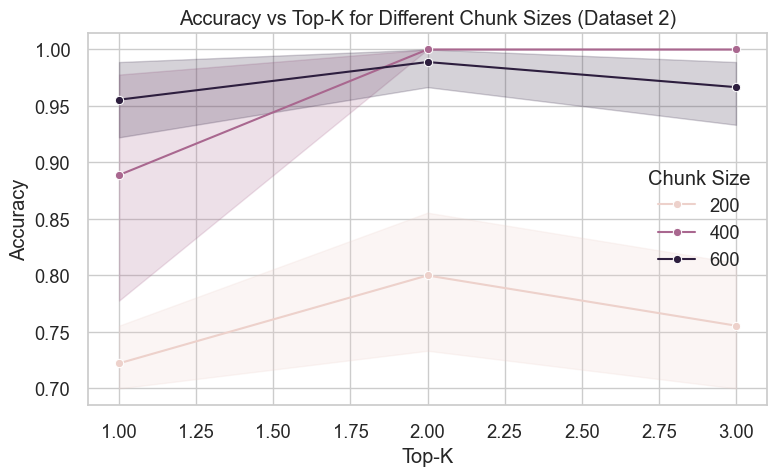

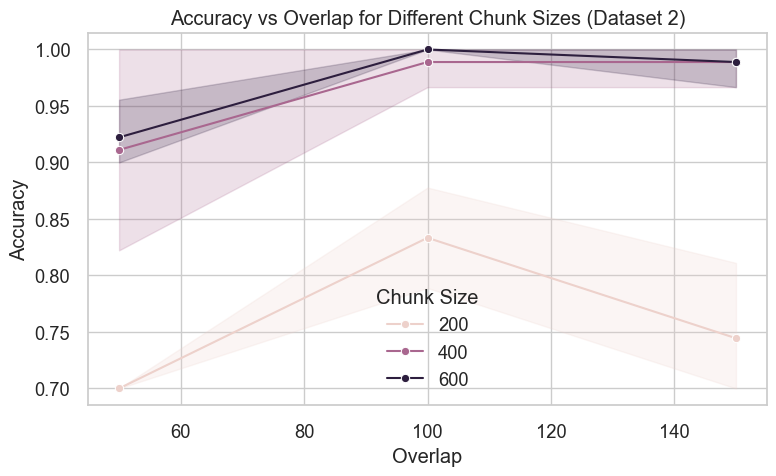

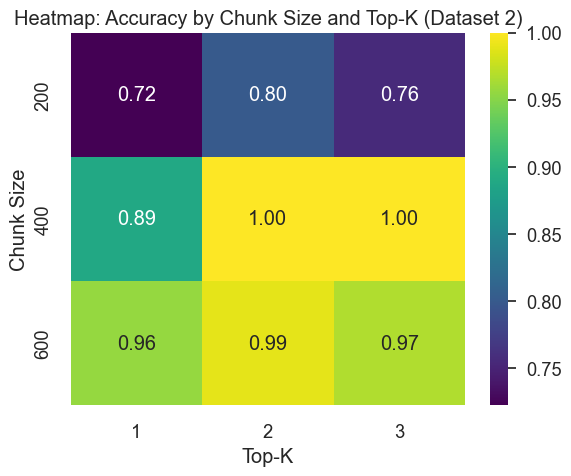

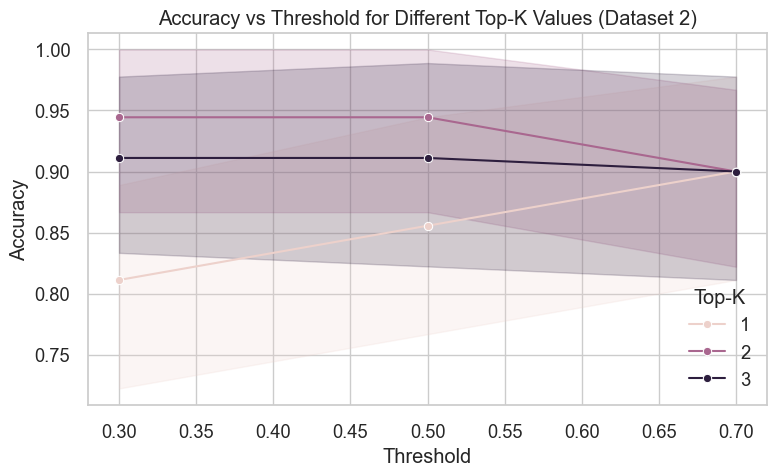

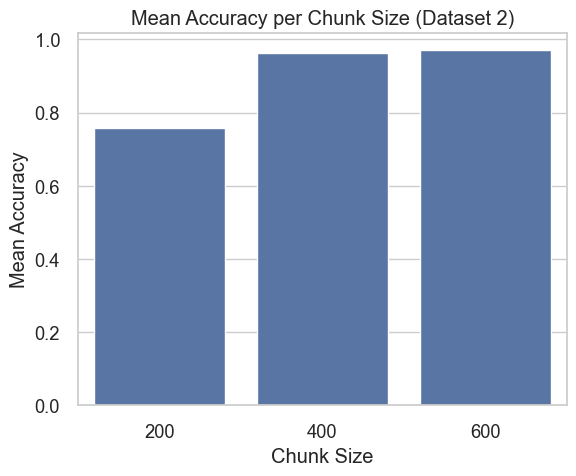

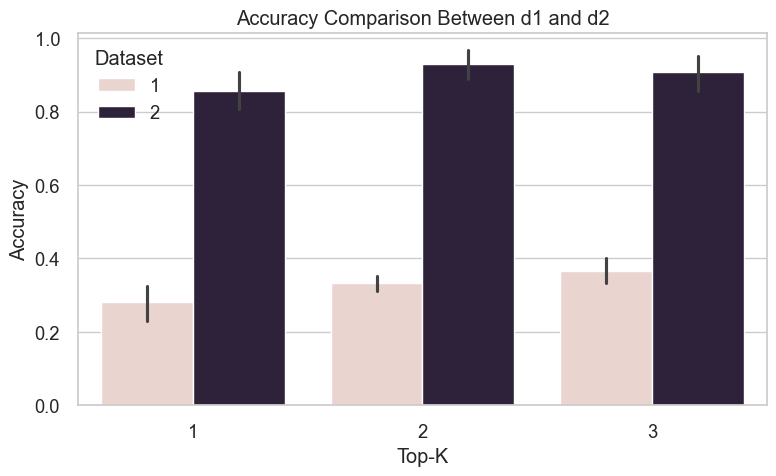

In [61]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Ensure dataset 2 (answerable subset) is prioritized
df2 = df[df["dataset"] == 2].copy()

sns.set(style="whitegrid", font_scale=1.2)

# 1️⃣ Accuracy vs Top-K (for each chunk size)
plt.figure(figsize=(8,5))
sns.lineplot(data=df2, x="k", y="accuracy", hue="cs", marker="o")
plt.title("Accuracy vs Top-K for Different Chunk Sizes (Dataset 2)")
plt.xlabel("Top-K")
plt.ylabel("Accuracy")
plt.legend(title="Chunk Size")
plt.tight_layout()
plt.savefig("accuracy_vs_topk.png")
plt.show()

# 2️⃣ Accuracy vs Overlap (grouped by chunk size)
plt.figure(figsize=(8,5))
sns.lineplot(data=df2, x="ov", y="accuracy", hue="cs", marker="o")
plt.title("Accuracy vs Overlap for Different Chunk Sizes (Dataset 2)")
plt.xlabel("Overlap")
plt.ylabel("Accuracy")
plt.legend(title="Chunk Size")
plt.tight_layout()
plt.savefig("accuracy_vs_overlap.png")
plt.show()

# 3️⃣ Heatmap of Accuracy (Chunk Size × Top-K)
heatmap_data = df2.groupby(["cs", "k"])["accuracy"].mean().unstack()
plt.figure(figsize=(6,5))
sns.heatmap(heatmap_data, annot=True, cmap="viridis", fmt=".2f")
plt.title("Heatmap: Accuracy by Chunk Size and Top-K (Dataset 2)")
plt.xlabel("Top-K")
plt.ylabel("Chunk Size")
plt.tight_layout()
plt.savefig("heatmap_chunk_topk.png")
plt.show()

# 4️⃣ Threshold Sensitivity
plt.figure(figsize=(8,5))
sns.lineplot(data=df2, x="th", y="accuracy", hue="k", marker="o")
plt.title("Accuracy vs Threshold for Different Top-K Values (Dataset 2)")
plt.xlabel("Threshold")
plt.ylabel("Accuracy")
plt.legend(title="Top-K")
plt.tight_layout()
plt.savefig("accuracy_vs_threshold.png")
plt.show()

# 5️⃣ Mean Accuracy per Chunk Size
mean_acc = df2.groupby("cs")["accuracy"].mean().reset_index()
plt.figure(figsize=(6,5))
sns.barplot(data=mean_acc, x="cs", y="accuracy")
plt.title("Mean Accuracy per Chunk Size (Dataset 2)")
plt.xlabel("Chunk Size")
plt.ylabel("Mean Accuracy")
plt.tight_layout()
plt.savefig("mean_accuracy_per_chunk_size.png")
plt.show()

# 6️⃣ Comparative Plot: d1 vs d2
plt.figure(figsize=(8,5))
sns.barplot(data=df, x="k", y="accuracy", hue="dataset")
plt.title("Accuracy Comparison Between d1 and d2")
plt.xlabel("Top-K")
plt.ylabel("Accuracy")
plt.legend(title="Dataset")
plt.tight_layout()
plt.savefig("d1_vs_d2_comparison.png")
plt.show()


In [62]:
import pandas as pd

# ✅ Focus on dataset 2 (answerable subset)
df2 = df[df["dataset"] == 2].copy()

# -------------------------------------------------------------------
# 1️⃣ Detailed results table (each configuration)
# -------------------------------------------------------------------
detailed_table = df2[["cs", "ov", "k", "th", "accuracy"]].sort_values(
    by=["cs", "ov", "k", "th"]
)
print("### Detailed Results Table (Dataset 2) ###")
display(detailed_table.style.background_gradient(cmap="YlGn", subset=["accuracy"])
        .format({"accuracy": "{:.3f}"}))

# Save to CSV for submission or appendix
detailed_table.to_csv("detailed_results_d2.csv", index=False)

# -------------------------------------------------------------------
# 2️⃣ Aggregated summary table (mean accuracy by parameters)
# -------------------------------------------------------------------
summary_table = (
    df2.groupby(["cs", "ov", "k", "th"])["accuracy"]
    .mean()
    .reset_index()
    .sort_values(by="accuracy", ascending=False)
)

print("\n### Summary Table (Mean Accuracy by Config) ###")
display(summary_table.style.background_gradient(cmap="viridis", subset=["accuracy"])
        .format({"accuracy": "{:.3f}"}))

# Save to CSV
summary_table.to_csv("summary_results_d2.csv", index=False)

# -------------------------------------------------------------------
# 3️⃣ Optional: Pivot table to show mean accuracy by chunk size and overlap
# -------------------------------------------------------------------
pivot = df2.pivot_table(
    index="cs", columns="ov", values="accuracy", aggfunc="mean"
)

print("\n### Pivot Table: Mean Accuracy (Chunk Size × Overlap) ###")
display(pivot.style.background_gradient(cmap="coolwarm", axis=None)
        .format("{:.3f}"))

pivot.to_csv("pivot_results_d2.csv")


### Detailed Results Table (Dataset 2) ###


,cs,ov,k,th,accuracy
99,200,50,1,0.300000,0.700
100,200,50,1,0.500000,0.700
101,200,50,1,0.700000,0.700
102,200,50,2,0.300000,0.700
103,200,50,2,0.500000,0.700
104,200,50,2,0.700000,0.700
105,200,50,3,0.300000,0.700
106,200,50,3,0.500000,0.700
107,200,50,3,0.700000,0.700
81,200,100,1,0.300000,0.700



### Summary Table (Mean Accuracy by Config) ###


,cs,ov,k,th,accuracy
48,400,150,2,0.300000,1.000
33,400,50,3,0.300000,1.000
34,400,50,3,0.500000,1.000
35,400,50,3,0.700000,1.000
37,400,100,1,0.500000,1.000
39,400,100,2,0.300000,1.000
38,400,100,1,0.700000,1.000
40,400,100,2,0.500000,1.000
41,400,100,2,0.700000,1.000
46,400,150,1,0.500000,1.000



### Pivot Table: Mean Accuracy (Chunk Size × Overlap) ###


ov,50,100,150
cs,,,
200,0.700,0.833,0.744
400,0.911,0.989,0.989
600,0.922,1.000,0.989


## End of Part 1

You must submit:  
- The **current notebook file** (`.ipynb`).  
- Its **Python conversion** (`.py` file).  
- The **Report** (`.pdf`).
- Run **files** (`.txt`).

All files should be placed inside a folder named "RollNumber_PA1". This folder must also include your **Part 2 files**, and the entire folder should be **zipped and submitted**.